# Causal Effect Estimation with the Generalized Adjustment Criterion - Example Notebook

The backdoor criterion, while very useful, is not complete, e.g. there are some valid adjustment sets which do not satisfy the backdoor criterion. This notebook gives an example where the backdoor criterion finds no adjustment sets, but by using the generalized adjustment algorithm one can still use covariate adjustment to estimate the causal effect.

In [1]:
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

In [44]:
# Define the graph
treatments = ["X1", "X2"]
outcome = "Y"
variables = ["V1", "V2", "V3", "V4", "V5"]
edges = [
    ("V5", "X1"),
    ("V4", "X1"),
    ("X1", "V1"),
    ("V1", "V2"),
    ("V2", "X2"),
    ("X2", "Y"),
    ("X1", "V3"),
    ("V3", "Y"),
    ("L", "V3"),
    ("L", "V2"),
]
graph = nx.DiGraph(edges)
data = dowhy.datasets.linear_dataset_from_graph(
    graph, 
    treatments=treatments, 
    outcome=outcome, 
    treatments_are_binary=True,
    outcome_is_binary=False,
    num_samples=10_000
)
data['df'].head()

,L,V4,V5,X1,V1,V3,V2,X2,Y
0,-0.285453,-0.634205,-0.829879,1,-0.689395,-0.159391,1.472056,1,0.983598
1,-0.765150,1.840856,0.364065,1,-0.195452,-0.343018,-0.397037,0,-0.286198
2,0.424812,0.670598,-0.693397,0,0.481983,1.232096,0.764908,0,-0.169075
3,1.633208,-0.772012,-1.144497,0,-1.039779,0.682182,0.891705,1,0.335345
4,-0.568951,0.064867,-0.194460,0,1.816467,0.704929,0.175386,0,0.866810


Since this data was syntheticly generated, we have access to the true ATE from the random edge weights assigned to the given causal graph.

In [47]:
data["ate"]

We now drop "L" from the dataset, as L will be unobserved.

In [50]:
data['df'] = data['df'].drop(columns='L', inplace=False)  # L is unobserved
df=data['df']
df.head()

,V4,V5,X1,V1,V3,V2,X2,Y
0,-0.634205,-0.829879,1,-0.689395,-0.159391,1.472056,1,0.983598
1,1.840856,0.364065,1,-0.195452,-0.343018,-0.397037,0,-0.286198
2,0.670598,-0.693397,0,0.481983,1.232096,0.764908,0,-0.169075
3,-0.772012,-1.144497,0,-1.039779,0.682182,0.891705,1,0.335345
4,0.064867,-0.194460,0,1.816467,0.704929,0.175386,0,0.866810


In [52]:
model = CausalModel(data=data["df"],
                    treatment=data["treatment_name"], outcome=data["outcome_name"],
                    graph=data["gml_graph"])

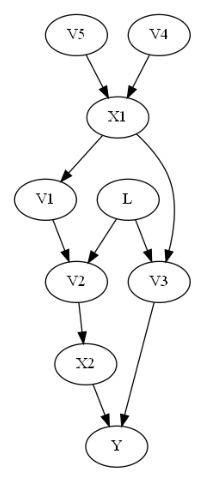

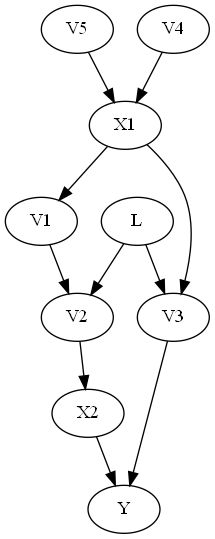

In [54]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The backdoor criterion requires the adjustment set **Z** to (1) contain no descendents of **X** and (2) to d-separate all backdoor paths from **X** to **Y**. In this case, in the above graph, the backdoor criterion would require the adjustment set to include L (since V2 and V3 are descendents of **X**). But if L is unobserved, then we cannot control for L, and so the backdoor criterion finds no adjustment sets.

The generalized adjustment criterion given in Perković et al. (2018) however is complete, and is able to identify that in fact {V1, V2} is a valid adjustment set. One can use this adjustment criterion to identify an estimand by using the 'identify_effect()' method in the CausalModel class, which gives a minimal adjustment set which meets the general adjustment criterion. One can then use convariate adjustment to estimate the causal effect given this estimad.

In [57]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                  -1⎤
 ⎢    d        ⎛    ∂              ⎞  ⎥
E⎢─────────(Y)⋅⎜─────────([X₁  X₂])⎟  ⎥
 ⎣d[V₅  V₄]    ⎝∂[V₅  V₄]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{V5,V4})
Estimand assumption 2, Exclusion: If we remove {V5,V4}→{X1,X2}, then ¬({V5,V4}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                
─────────(E[Y|V1,V2])
d[X₁  X₂]            
Estimand assumption 1, Unconfoundedness: If U→{X1,X2} and U→Y then P(Y|X1,X2,V1,V2,U) = P(Y|X1,X2,V1,V2)



### Computing the Estimate

We can now use the covariate adjustment set identified by the general adjustment criterion used in the identify_effect() method. We can compare this to the ground truth ATE of the data from above.

In [60]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="general_adjustment.linear_regression",
                                        control_value=(0,0),
                                        treatment_value=(1,1),
                                        method_params={'need_conditional_estimates': False})
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: general_adjustment
Estimand expression:
    d                
─────────(E[Y|V1,V2])
d[X₁  X₂]            
Estimand assumption 1, Unconfoundedness: If U→{X1,X2} and U→Y then P(Y|X1,X2,V1,V2,U) = P(Y|X1,X2,V1,V2)

## Realized estimand
b: Y~X1+X2+V1+V2
Target units: ate

## Estimate
Mean value: 0.7697765002235358

